# Brain Cancer MRI Images Classification

Cancer is the second leading cause of death after cardiovascular diseases. Out of all types of cancer, brain cancer has the lowest survival rate. Brain tumors can have different types depending on several factors such as the shape, texture, and location of the tumor (e.g., Acoustic Neuroma, Meningioma, Pituitary, Glioma, CNS Lymphoma . . . etc). In clinical practice, the incident rates of Glioma, Meningioma, and Pituitary tumors are approximately 45%, 15%, and 15%, respectively, among all brain tumors. Proper diagnosis of the tumor type enables the doctor to make the correct treatment choice and help save the patient’s life.


Currently, anomaly detection through MRI is manual mostly and clinicians have to spend a lot of time to detect and segment the tumor for treatment and surgical purpose. This manual technique is also prone to errors and can compromise life. Also, diversity of Tumor types, makes the detection more difficult due to the complex structure of the brain. In order to resolve these issues, studies have started to focus on various machine learning and Deep Learning techniques for computer-based tumor detection and segmentation.


 [This paper](https://www.sciencedirect.com/science/article/abs/pii/S0895611121000896?via%3Dihub) reviews different papers that tried to do the task of brain cancer MRI image classification. In this homework, we will implement and compare some of these methods.

First, import all the libraries you may need here:

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
from PIL import Image
from random import shuffle
from google.colab import drive
import os
import random
from distutils.dir_util import copy_tree
import tensorflow as tf
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import Model, layers


## 1. Load Data (5 pt)

We have a dataset of 3064 T1-weighted contrast-enhanced MRI images of 3 brain tumor types (Meningiomas, Gliomas, and Pituitary tumors). You are supposed to download and unzip the [data](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5).

We suggest loading all of the data in one folder in google drive.

In [10]:
#Using Colb
#Downling Dataset and unzip it in Data folder.
!wget https://figshare.com/ndownloader/articles/1512427/versions/5
!unzip /content/5 -d /content/data
!unzip /content/data/brainTumorDataPublic_1-766.zip -d /content/Data
!unzip /content/data/brainTumorDataPublic_767-1532.zip -d /content/Data
!unzip /content/data/brainTumorDataPublic_1533-2298.zip -d /content/Data
!unzip /content/data/brainTumorDataPublic_2299-3064.zip -d /content/Data

## 2. Visualize some Images (7 pt)

In this part, we want to show 2 random MRI images from each category in the dataset. As we have 3 types of tumors, we should have 6 images in the output.

In this dataset, the images are in matlab format and each image is stored as a struct that includes tumorMask, tumorBorder, image, PID (PatientID), label. The h5py library is used to read the photos in the code section. Using this library, we read the dataset images that are in mat format.

 Images are labeled this way in .mat files:

Label 1: meningioma

Label 2: glioma

Label 3: pituitary

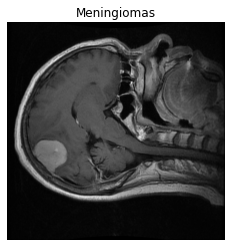

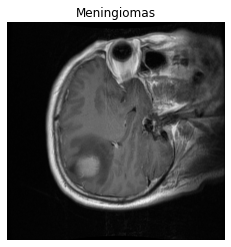

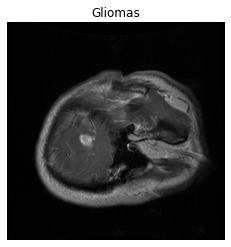

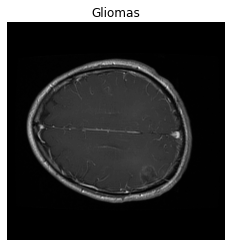

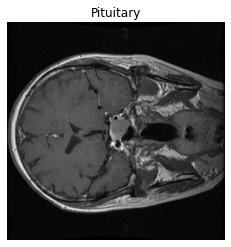

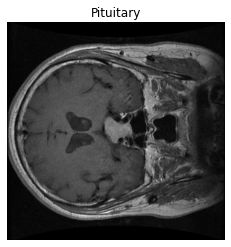

In [4]:
#Visualizing tow images of each category.
def get_images(Type, name):
    images = random.sample(Type, 2)
    for file in images:
        dset = file['cjdata']
        image = np.array(dset.get('image')).astype(np.float64)
        hi = np.max(image)
        lo = np.min(image)
        image = (((image -lo)/(hi-lo))*255).astype(np.uint8)
        imgplot = plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(name)
        plt.show() 

Meningiomas = []
Gliomas = []
Pituitary = []
All = []
files = os.listdir('/content/Data')
for file in files:
    f = h5py.File('/content/Data/' + file, 'r')
    dset = f['cjdata']
    label = dset.get('label')[0,0]
    All.append(f)
    if int(label) == 1:
        Meningiomas.append(f)
    elif int(label) == 2:
        Gliomas.append(f)
    else:
        Pituitary.append(f)

get_images(Meningiomas, 'Meningiomas')
get_images(Gliomas, 'Gliomas')
get_images(Pituitary, 'Pituitary')


## Split images to validation and train (10 pt)

Now, we want to save images in 3 different folders. Each folder should contain MRI images of one tumor type.

Then you should split data to train and validation. 80% of the data should be train and the rest should be validation.


In [5]:
#Create a folder for each category and Spliting the data to training and validation.
def mk_folder(Type, name, t_v):
    os.mkdir(f'{name}/{t_v}')
    i = 1
    for file in Type:
        dset = file['cjdata']
        image = np.array(dset.get('image')).astype(np.float64)
        hi = np.max(image)
        lo = np.min(image)
        image = (((image -lo)/(hi-lo))*255).astype(np.uint8)
        im = Image.fromarray(image)
        im.save(f'/content/{name}/{t_v}/{name[0]}_{t_v}_{i}.jpg')
        i += 1

os.mkdir('Meningiomas')
os.mkdir('Gliomas')
os.mkdir('Pituitary')
mk_folder(Meningiomas[:int(.8*len(Meningiomas))], 'Meningiomas', 'train')
mk_folder(Meningiomas[int(.8*len(Meningiomas)):], 'Meningiomas', 'val')
mk_folder(Gliomas[:int(.8*len(Gliomas))], 'Gliomas', 'train')
mk_folder(Gliomas[int(.8*len(Gliomas)):], 'Gliomas', 'val')
mk_folder(Pituitary[:int(.8*len(Pituitary))], 'Pituitary', 'train')
mk_folder(Pituitary[int(.8*len(Pituitary)):], 'Pituitary', 'val')

os.mkdir('training')
os.mkdir('validation')
for t in ['Meningiomas', 'Gliomas', 'Pituitary']:
    from_directory = f'/content/{t}/val'
    to_directory = f'/content/validation/{t}'
    copy_tree(from_directory, to_directory)
    from_directory = f'/content/{t}/train'
    to_directory = f'/content/training/{t}'
    copy_tree(from_directory, to_directory)


### Data Preprocessing (15 pt)

Medical images datasets are smaller in size than the datasets available in other domains due to their limitations. One way to overcome the problem of lack of sufficient amount of training data is data augmentation.

There are many type of manipulations that we can use for this target. Here are a list of some augmentation techniques that you can use in this task:

Horizontal and vertical flips

Rotation

Zooming

Shifting

Shearing

Brightness

ZCA whitening

In [6]:
#Preprocessing
train_dir =  '/content/training'
val_dir =  '/content/validation'
train_data = ImageDataGenerator(
        rescale = 1/255,
        shear_range = 10,
        zoom_range = .3,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = .2,
        rotation_range = 20,
        #zca_whitening=True,
        fill_mode = 'nearest'
    ) 
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
    rescale = 1/255
    )
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2450 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


## Implementing 3 Different Classification Models

Now we want to design models for MRI image classification. Models that we want to use are these:

1- ResNet50

2- AlexNet

3- Multi-layer perceptron

### ResNet Model Design, image level (20pt)

Now it's time to create the model. Here we use Residual Network architecture composed of 50 layers for our model. Set the optimizer to 'Adam' and learning rate to '0.0003' for 200 epoches. You can change settings like LR untill getting better performance.


In this task we consentrate on the content of [this paper](https://doi.org/10.1016/j.artmed.2019.101779).

In [12]:
#ResNet --> image level
base_model = keras.applications.ResNet50(weights = None,
                                         include_top = False,
                                         input_shape=(224,224,3))

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)

pred = keras.layers.Dense(traindata.num_classes, activation='softmax')(x)
ResNet_model = Model(inputs = base_model.input, outputs = pred)
opt = keras.optimizers.Adam(learning_rate=0.00003)
ResNet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])


In [13]:
ResNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Train the ResNet50 model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.


In [27]:
#Training ResNet
Res_history = ResNet_model.fit(traindata,validation_data = valdata, batch_size=32, epochs = 200)

Epoch 1/200
77/77 [==============================] - 186s 2s/step - loss: 1.2531 - accuracy: 0.5461 - recall_4: 0.4837 - precision_3: 0.5714 - val_loss: 1.6588 - val_accuracy: 0.4658 - val_recall_4: 0.4658 - val_precision_3: 0.4658
Epoch 2/200
77/77 [==============================] - 166s 2s/step - loss: 0.7908 - accuracy: 0.6763 - recall_4: 0.6282 - precision_3: 0.7122 - val_loss: 1.2739 - val_accuracy: 0.3225 - val_recall_4: 0.3078 - val_precision_3: 0.3264
Epoch 3/200
77/77 [==============================] - 166s 2s/step - loss: 0.6168 - accuracy: 0.7441 - recall_4: 0.7073 - precision_3: 0.7757 - val_loss: 3.7145 - val_accuracy: 0.3029 - val_recall_4: 0.3029 - val_precision_3: 0.3029
Epoch 4/200
77/77 [==============================] - 168s 2s/step - loss: 0.5180 - accuracy: 0.7812 - recall_4: 0.7531 - precision_3: 0.8074 - val_loss: 3.3888 - val_accuracy: 0.4739 - val_recall_4: 0.4739 - val_precision_3: 0.4747
Epoch 5/200
77/77 [==============================] - 163s 2s/step - loss

77/77 [==============================] - 1199s 16s/step - loss: 0.1104 - accuracy: 0.9629 - recall_4: 0.9592 - precision_3: 0.9663 - val_loss: 0.3820 - val_accuracy: 0.8550 - val_recall_4: 0.8534 - val_precision_3: 0.8590
Epoch 72/200
77/77 [==============================] - 319s 4s/step - loss: 0.0804 - accuracy: 0.9682 - recall_4: 0.9678 - precision_3: 0.9705 - val_loss: 1.2349 - val_accuracy: 0.7313 - val_recall_4: 0.7313 - val_precision_3: 0.7349
Epoch 73/200
77/77 [==============================] - 339s 4s/step - loss: 0.1202 - accuracy: 0.9571 - recall_4: 0.9559 - precision_3: 0.9602 - val_loss: 1.7996 - val_accuracy: 0.6580 - val_recall_4: 0.6564 - val_precision_3: 0.6607
Epoch 74/200
77/77 [==============================] - 341s 4s/step - loss: 0.0929 - accuracy: 0.9661 - recall_4: 0.9649 - precision_3: 0.9681 - val_loss: 0.9585 - val_accuracy: 0.6840 - val_recall_4: 0.6824 - val_precision_3: 0.6858
Epoch 75/200
77/77 [==============================] - 340s 4s/step - loss: 0.11

77/77 [==============================] - 181s 2s/step - loss: 0.0480 - accuracy: 0.9845 - recall_4: 0.9833 - precision_3: 0.9853 - val_loss: 1.8535 - val_accuracy: 0.6140 - val_recall_4: 0.6124 - val_precision_3: 0.6154
Epoch 142/200
77/77 [==============================] - 183s 2s/step - loss: 0.0350 - accuracy: 0.9865 - recall_4: 0.9865 - precision_3: 0.9865 - val_loss: 0.1274 - val_accuracy: 0.9658 - val_recall_4: 0.9658 - val_precision_3: 0.9658
Epoch 143/200
77/77 [==============================] - 177s 2s/step - loss: 0.0468 - accuracy: 0.9845 - recall_4: 0.9841 - precision_3: 0.9849 - val_loss: 0.1974 - val_accuracy: 0.9365 - val_recall_4: 0.9365 - val_precision_3: 0.9395
Epoch 144/200
77/77 [==============================] - 211s 3s/step - loss: 0.0612 - accuracy: 0.9812 - recall_4: 0.9804 - precision_3: 0.9820 - val_loss: 0.3826 - val_accuracy: 0.9137 - val_recall_4: 0.9121 - val_precision_3: 0.9165
Epoch 145/200
77/77 [==============================] - 198s 3s/step - loss: 0.

77/77 [==============================] - 197s 3s/step - loss: 0.0430 - accuracy: 0.9841 - recall_4: 0.9841 - precision_3: 0.9845 - val_loss: 0.2541 - val_accuracy: 0.9316 - val_recall_4: 0.9283 - val_precision_3: 0.9329
Epoch 177/200
77/77 [==============================] - 200s 3s/step - loss: 0.0274 - accuracy: 0.9886 - recall_4: 0.9878 - precision_3: 0.9890 - val_loss: 0.3393 - val_accuracy: 0.9235 - val_recall_4: 0.9235 - val_precision_3: 0.9235
Epoch 178/200
77/77 [==============================] - 221s 3s/step - loss: 0.0296 - accuracy: 0.9910 - recall_4: 0.9906 - precision_3: 0.9910 - val_loss: 0.1945 - val_accuracy: 0.9544 - val_recall_4: 0.9544 - val_precision_3: 0.9560
Epoch 179/200
77/77 [==============================] - 205s 3s/step - loss: 0.0373 - accuracy: 0.9878 - recall_4: 0.9878 - precision_3: 0.9882 - val_loss: 0.4800 - val_accuracy: 0.8811 - val_recall_4: 0.8795 - val_precision_3: 0.8809
Epoch 180/200
77/77 [==============================] - 207s 3s/step - loss: 0.

In [ ]:
# I forgot to calculate F1-score during the training. 
# Since it was time consuming to train it again, I calculate F1-score separately.
temp1 = [2*a*b for a,b in zip(Res_history.history['val_precision_3'] , Res_history.history['val_recall_4'])]
temp2 = [a+b for a,b in zip(Res_history.history['val_precision_3'] , Res_history.history['val_recall_4'])]
F1_score = [a/b for a,b in zip(temp1, temp2)]

###Loss and accuracy diagrams for ResNet50 (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

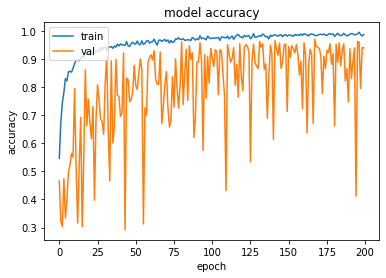

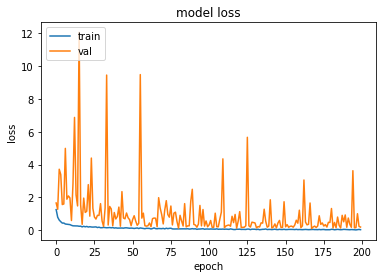

In [28]:
#Analyze ResNet.
plt.plot(Res_history.history['accuracy'])
plt.plot(Res_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Res_history.history['loss'])
plt.plot(Res_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

    We reached out %97 accuracy.
    I tested smaller lr and got better performance.
    I guess if i decreased lr to the number in paper and had more epochs(like 500 in paper), we had less variance

###ResNet Model, Patient level (30 pt)


Here we want to repeat ResNet model in a different way. You should do all the steps again with a difference in spliting the data. In patient level you should pay attention that all the images from a patient should be either in train or validation.

So, do the spliting part of data with considering this point and then do all the steps again (design the model, train the model, plot accuracy and loss diagrams).


How different are the results?

Which method do yo think is better? Which results are more reliable? Image level method or patient level method?

In [83]:
#Getting ready again for patient level
PID = []
MPID = []
GPID = []
PPID = []
def get_pid(Type):
    for file in Type:
        dset = file['cjdata']
        pid = dset.get('PID') 
        pid = ''.join(chr(c[0]) for c in pid)
        label = dset.get('label')[0,0]
        if int(label) == 1:
            MPID.append(pid)
        elif int(label) == 2:
            GPID.append(pid)
        else:
            PPID.append(pid)
        PID.append(pid)

get_pid(Meningiomas)
get_pid(Gliomas)
get_pid(Pituitary)

os.mkdir('train')
os.mkdir('val')
os.mkdir('train/Meningiomas')
os.mkdir('train/Gliomas')
os.mkdir('train/Pituitary')
os.mkdir('val/Meningiomas')
os.mkdir('val/Gliomas')
os.mkdir('val/Pituitary')

In [85]:
#Spliting the data --> patient level
def getim(pid, T_V):
    if pid in MPID:
        i = 1
        for el in Meningiomas:
            dset = el['cjdata']
            p = dset.get('PID') 
            p = ''.join(chr(c[0]) for c in p)
            if pid == p:
                image = np.array(dset.get('image')).astype(np.float64)
                hi = np.max(image)
                lo = np.min(image)
                image = (((image -lo)/(hi-lo))*255).astype(np.uint8)
                im = Image.fromarray(image)
                im.save(f'/content/{T_V}/Meningiomas/{pid}_{i}.jpg')
                i += 1
        return
    if pid in GPID:
        i = 1
        for el in Gliomas:
            dset = el['cjdata']
            p = dset.get('PID') 
            p = ''.join(chr(c[0]) for c in p)
            if pid == p:
                image = np.array(dset.get('image')).astype(np.float64)
                hi = np.max(image)
                lo = np.min(image)
                image = (((image -lo)/(hi-lo))*255).astype(np.uint8)
                im = Image.fromarray(image)
                im.save(f'/content/{T_V}/Gliomas/{pid}_{i}.jpg')
                i += 1
        return
    if pid in PPID:
        i = 1
        for el in Pituitary:
            dset = el['cjdata']
            p = dset.get('PID') 
            p = ''.join(chr(c[0]) for c in p)
            if pid == p:
                image = np.array(dset.get('image')).astype(np.float64)
                hi = np.max(image)
                lo = np.min(image)
                image = (((image -lo)/(hi-lo))*255).astype(np.uint8)
                im = Image.fromarray(image)
                im.save(f'/content/{T_V}/Pituitary/{pid}_{i}.jpg')
                i += 1
        return

shuffle(PID)
PID = list(set(PID))
for pid in PID[:int(.8*len(PID))]:
    getim(pid, 'train')
for pid in PID[int(.8*len(PID)):]:
    getim(pid, 'val')


In [104]:
#Preprocessing
train_dir =  '/content/train'
val_dir =  '/content/val'
train_data = ImageDataGenerator(
        rescale = 1/255,
        shear_range = 10,
        zoom_range = .3,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = .2,
        rotation_range = 20,
        #zca_whitening=True,
        fill_mode = 'nearest'
    ) 
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
    rescale = 1/255
    )
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2488 images belonging to 3 classes.
Found 576 images belonging to 3 classes.


In [30]:
# ResNet --> patient level
base_model = keras.applications.ResNet50(weights = None,
                                         include_top = False,
                                         input_shape=(224,224,3))

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)

pred = keras.layers.Dense(traindata.num_classes, activation='softmax')(x)
ResNet_model = Model(inputs = base_model.input, outputs = pred)
opt = keras.optimizers.Adam(learning_rate=0.0003)
ResNet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [31]:
# Training --> patient level
Res2_history = ResNet_model.fit(traindata,validation_data = valdata, batch_size=32, epochs = 200)

Epoch 1/200
78/78 [==============================] - 170s 2s/step - loss: 1.3229 - accuracy: 0.5485 - recall_5: 0.4931 - precision_4: 0.5699 - val_loss: 1.4471 - val_accuracy: 0.4628 - val_recall_5: 0.4628 - val_precision_4: 0.4628
Epoch 2/200
78/78 [==============================] - 163s 2s/step - loss: 0.8029 - accuracy: 0.6622 - recall_5: 0.5939 - precision_4: 0.6902 - val_loss: 1.5042 - val_accuracy: 0.3598 - val_recall_5: 0.3598 - val_precision_4: 0.3598
Epoch 3/200
78/78 [==============================] - 176s 2s/step - loss: 0.6748 - accuracy: 0.7168 - recall_5: 0.6642 - precision_4: 0.7474 - val_loss: 1.5362 - val_accuracy: 0.3598 - val_recall_5: 0.3598 - val_precision_4: 0.3598
Epoch 4/200
78/78 [==============================] - 175s 2s/step - loss: 0.5634 - accuracy: 0.7739 - recall_5: 0.7338 - precision_4: 0.7998 - val_loss: 3.7456 - val_accuracy: 0.4628 - val_recall_5: 0.4628 - val_precision_4: 0.4628
Epoch 5/200
78/78 [==============================] - 176s 2s/step - loss

78/78 [==============================] - 165s 2s/step - loss: 0.1000 - accuracy: 0.9612 - recall_5: 0.9608 - precision_4: 0.9643 - val_loss: 0.7865 - val_accuracy: 0.7770 - val_recall_5: 0.7736 - val_precision_4: 0.7802
Epoch 72/200
78/78 [==============================] - 163s 2s/step - loss: 0.1055 - accuracy: 0.9616 - recall_5: 0.9587 - precision_4: 0.9626 - val_loss: 2.1147 - val_accuracy: 0.4223 - val_recall_5: 0.4223 - val_precision_4: 0.4237
Epoch 73/200
78/78 [==============================] - 165s 2s/step - loss: 0.0830 - accuracy: 0.9701 - recall_5: 0.9697 - precision_4: 0.9724 - val_loss: 0.2186 - val_accuracy: 0.9257 - val_recall_5: 0.9257 - val_precision_4: 0.9352
Epoch 74/200
78/78 [==============================] - 164s 2s/step - loss: 0.1057 - accuracy: 0.9604 - recall_5: 0.9591 - precision_4: 0.9615 - val_loss: 1.2303 - val_accuracy: 0.6098 - val_recall_5: 0.6081 - val_precision_4: 0.6133
Epoch 75/200
78/78 [==============================] - 180s 2s/step - loss: 0.0827

78/78 [==============================] - 162s 2s/step - loss: 0.0568 - accuracy: 0.9830 - recall_5: 0.9830 - precision_4: 0.9846 - val_loss: 0.6457 - val_accuracy: 0.8480 - val_recall_5: 0.8480 - val_precision_4: 0.8494
Epoch 142/200
78/78 [==============================] - 458s 6s/step - loss: 0.0976 - accuracy: 0.9672 - recall_5: 0.9660 - precision_4: 0.9680 - val_loss: 0.7523 - val_accuracy: 0.8328 - val_recall_5: 0.8294 - val_precision_4: 0.8322
Epoch 143/200
78/78 [==============================] - 327s 4s/step - loss: 0.0624 - accuracy: 0.9782 - recall_5: 0.9782 - precision_4: 0.9786 - val_loss: 1.4042 - val_accuracy: 0.8159 - val_recall_5: 0.8159 - val_precision_4: 0.8200
Epoch 144/200
78/78 [==============================] - 201s 3s/step - loss: 0.0509 - accuracy: 0.9806 - recall_5: 0.9802 - precision_4: 0.9814 - val_loss: 1.3014 - val_accuracy: 0.7196 - val_recall_5: 0.7179 - val_precision_4: 0.7216
Epoch 145/200
78/78 [==============================] - 191s 2s/step - loss: 0.

78/78 [==============================] - 161s 2s/step - loss: 0.0410 - accuracy: 0.9862 - recall_5: 0.9858 - precision_4: 0.9870 - val_loss: 0.6615 - val_accuracy: 0.8953 - val_recall_5: 0.8936 - val_precision_4: 0.8981
Epoch 177/200
78/78 [==============================] - 163s 2s/step - loss: 0.0357 - accuracy: 0.9862 - recall_5: 0.9862 - precision_4: 0.9862 - val_loss: 0.4265 - val_accuracy: 0.9003 - val_recall_5: 0.9003 - val_precision_4: 0.9019
Epoch 178/200
78/78 [==============================] - 162s 2s/step - loss: 0.0298 - accuracy: 0.9907 - recall_5: 0.9903 - precision_4: 0.9919 - val_loss: 3.4145 - val_accuracy: 0.5963 - val_recall_5: 0.5946 - val_precision_4: 0.5966
Epoch 179/200
78/78 [==============================] - 164s 2s/step - loss: 0.0478 - accuracy: 0.9842 - recall_5: 0.9834 - precision_4: 0.9842 - val_loss: 1.3002 - val_accuracy: 0.8125 - val_recall_5: 0.8125 - val_precision_4: 0.8125
Epoch 180/200
78/78 [==============================] - 162s 2s/step - loss: 0.

In [ ]:
# I forgot to calculate F1-score during the training. 
# Since it was time consuming to train it again, I calculate F1-score separately.
temp1 = [2*a*b for a,b in zip(Res2_history.history['val_precision_4'] , Res2_history.history['val_recall_5'])]
temp2 = [a+b for a,b in zip(Res2_history.history['val_precision_4'] , Res2_history.history['val_recall_5'])]
F1_score = [a/b for a,b in zip(temp1, temp2)]

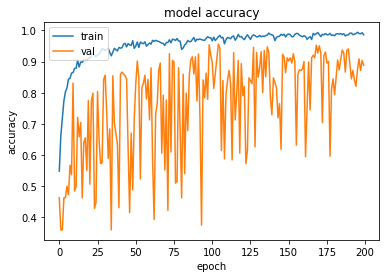

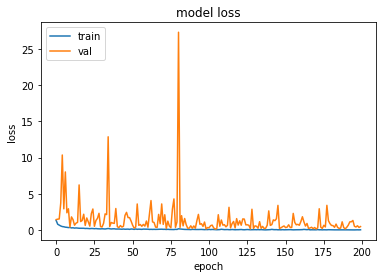

In [33]:
#Analyze ResNet --> patient level
plt.plot(Res2_history.history['accuracy'])
plt.plot(Res2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Res2_history.history['loss'])
plt.plot(Res2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The accuracy of the patient level is lower because in the image level, it had already seen the images of a particular patient, and it was better for the model to predict a new image (maybe the model had already seen some of the image of a patient).

But the patient level is more reliable, because we want to predict a new patient image that the model has not already seen it(none of his/her image). So it is better to use patient level because it is closer to reality.

## 1. AlexNet Model Design (20 pt)

Now we want to test another model. We will use AlexNet here.

Run it for 100 epoches. You can change settings to get better performance.

set optimizer = 'Adam' and loss = 'categorical_crossentropy'.



In [2]:
# Building AlexNet

np.random.seed(1000)

AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='valid'))
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

AlexNet.add(Flatten())
AlexNet.add(Dense(4096, input_shape=(227*227*3,)))
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(4096))
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(3))
AlexNet.add(Activation('softmax'))


In [44]:
AlexNet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 activation_39 (Activation)  (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 activation_40 (Activation)  (None, 22, 22, 256)       0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                 

### Train the AlexNet model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.

In [3]:
#Preprocessing AlexNet Image level
train_dir =  '/content/training'
val_dir =  '/content/validation'
train_data = ImageDataGenerator(
        rescale = 1/255,
        shear_range = 10,
        zoom_range = .3,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = .2,
        rotation_range = 20,
        #zca_whitening=True,
        fill_mode = 'nearest'
    ) 
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
    rescale = 1/255
    )
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2450 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [4]:
#AlexNet --> Image level
opt = keras.optimizers.Adam(learning_rate=0.00001)
AlexNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [5]:
# Training AlexNet --> Image level
Alex_history = AlexNet.fit(traindata,validation_data = valdata, batch_size=32, epochs = 100)

Epoch 1/100
77/77 [==============================] - 32s 402ms/step - loss: 1.0793 - accuracy: 0.4551 - recall: 0.0188 - precision: 0.3151 - val_loss: 1.0708 - val_accuracy: 0.4658 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
77/77 [==============================] - 28s 365ms/step - loss: 1.0670 - accuracy: 0.4653 - recall: 0.0053 - precision: 0.2321 - val_loss: 1.0659 - val_accuracy: 0.4658 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
77/77 [==============================] - 28s 360ms/step - loss: 1.0489 - accuracy: 0.4649 - recall: 0.0747 - precision: 0.5126 - val_loss: 1.0466 - val_accuracy: 0.4658 - val_recall: 0.0293 - val_precision: 0.6667
Epoch 4/100
77/77 [==============================] - 28s 360ms/step - loss: 1.0101 - accuracy: 0.5082 - recall: 0.1951 - precision: 0.6005 - val_loss: 1.0425 - val_accuracy: 0.4397 - val_recall: 0.0407 - val_precision: 0.7353
Epoch 5/100
77/77 [==============================] - 29s 376ms/step - loss: 0.98

77/77 [==============================] - 30s 394ms/step - loss: 0.3893 - accuracy: 0.8363 - recall: 0.8127 - precision: 0.8653 - val_loss: 0.3846 - val_accuracy: 0.8257 - val_recall: 0.8046 - val_precision: 0.8562
Epoch 74/100
77/77 [==============================] - 30s 381ms/step - loss: 0.3888 - accuracy: 0.8412 - recall: 0.8180 - precision: 0.8582 - val_loss: 0.6391 - val_accuracy: 0.7345 - val_recall: 0.7150 - val_precision: 0.7543
Epoch 75/100
77/77 [==============================] - 31s 408ms/step - loss: 0.4402 - accuracy: 0.8131 - recall: 0.7906 - precision: 0.8310 - val_loss: 0.4215 - val_accuracy: 0.8225 - val_recall: 0.7932 - val_precision: 0.8529
Epoch 76/100
77/77 [==============================] - 31s 407ms/step - loss: 0.4084 - accuracy: 0.8306 - recall: 0.8094 - precision: 0.8566 - val_loss: 0.5238 - val_accuracy: 0.7769 - val_recall: 0.7541 - val_precision: 0.8109
Epoch 77/100
77/77 [==============================] - 31s 404ms/step - loss: 0.4008 - accuracy: 0.8343 - 

In [ ]:
# I forgot to calculate F1-score during the training. 
# Since it was time consuming to train it again, I calculate F1-score separately.
temp1 = [2*a*b for a,b in zip(Alex_history.history['val_precision'] , Alex_history.history['val_recall'])]
temp2 = [a+b for a,b in zip(Alex_history.history['val_precision'] , Alex_history.history['val_recall'])]
F1_score = [a/b for a,b in zip(temp1, temp2)]

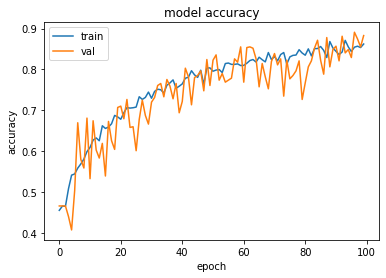

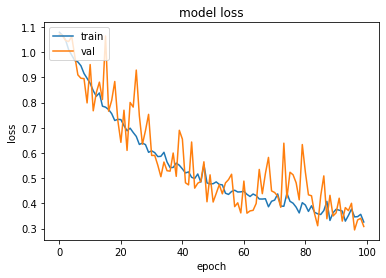

In [6]:
#Analyze AlexNet Image Level
plt.plot(Alex_history.history['accuracy'])
plt.plot(Alex_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Alex_history.history['loss'])
plt.plot(Alex_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Preprocessing AlexNet patient level
train_dir =  '/content/train'
val_dir =  '/content/val'
train_data = ImageDataGenerator(
        rescale = 1/255,
        shear_range = 10,
        zoom_range = .3,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = .2,
        rotation_range = 20,
        #zca_whitening=True,
        fill_mode = 'nearest'
    ) 
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
    rescale = 1/255
    )
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

In [46]:
#AlexNet --> Patient level
opt = keras.optimizers.Adam(learning_rate=0.00001)
AlexNet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [47]:
# Training AlexNet --> Patient level
Alex_history = AlexNet.fit(traindata,validation_data = valdata, batch_size=32, epochs = 100)

Epoch 1/100
78/78 [==============================] - 37s 436ms/step - loss: 1.0806 - accuracy: 0.4600 - recall_7: 0.0000e+00 - precision_6: 0.0000e+00 - val_loss: 1.0584 - val_accuracy: 0.4628 - val_recall_7: 0.0000e+00 - val_precision_6: 0.0000e+00
Epoch 2/100
78/78 [==============================] - 29s 366ms/step - loss: 1.0680 - accuracy: 0.4660 - recall_7: 0.0150 - precision_6: 0.3491 - val_loss: 1.0489 - val_accuracy: 0.4628 - val_recall_7: 0.0068 - val_precision_6: 0.5000
Epoch 3/100
78/78 [==============================] - 29s 370ms/step - loss: 1.0555 - accuracy: 0.4660 - recall_7: 0.0409 - precision_6: 0.4208 - val_loss: 1.0299 - val_accuracy: 0.4628 - val_recall_7: 0.1723 - val_precision_6: 0.6145
Epoch 4/100
78/78 [==============================] - 29s 366ms/step - loss: 1.0235 - accuracy: 0.4935 - recall_7: 0.1468 - precision_6: 0.5007 - val_loss: 0.9705 - val_accuracy: 0.6318 - val_recall_7: 0.0338 - val_precision_6: 0.6897
Epoch 5/100
78/78 [=============================

Epoch 36/100
78/78 [==============================] - 29s 373ms/step - loss: 0.5283 - accuracy: 0.7763 - recall_7: 0.7282 - precision_6: 0.8072 - val_loss: 0.5073 - val_accuracy: 0.7973 - val_recall_7: 0.7584 - val_precision_6: 0.8284
Epoch 37/100
78/78 [==============================] - 29s 372ms/step - loss: 0.5441 - accuracy: 0.7690 - recall_7: 0.7346 - precision_6: 0.7986 - val_loss: 0.5204 - val_accuracy: 0.7855 - val_recall_7: 0.7483 - val_precision_6: 0.8143
Epoch 38/100
78/78 [==============================] - 29s 373ms/step - loss: 0.5319 - accuracy: 0.7771 - recall_7: 0.7379 - precision_6: 0.8067 - val_loss: 0.4439 - val_accuracy: 0.8277 - val_recall_7: 0.7956 - val_precision_6: 0.8564
Epoch 39/100
78/78 [==============================] - 29s 372ms/step - loss: 0.5002 - accuracy: 0.7836 - recall_7: 0.7431 - precision_6: 0.8128 - val_loss: 0.5180 - val_accuracy: 0.7770 - val_recall_7: 0.7466 - val_precision_6: 0.8022
Epoch 40/100
78/78 [==============================] - 29s 37

Epoch 71/100
78/78 [==============================] - 29s 374ms/step - loss: 0.3952 - accuracy: 0.8329 - recall_7: 0.8111 - precision_6: 0.8532 - val_loss: 0.3571 - val_accuracy: 0.8514 - val_recall_7: 0.8243 - val_precision_6: 0.8683
Epoch 72/100
78/78 [==============================] - 29s 375ms/step - loss: 0.4091 - accuracy: 0.8261 - recall_7: 0.8062 - precision_6: 0.8463 - val_loss: 0.3628 - val_accuracy: 0.8514 - val_recall_7: 0.8345 - val_precision_6: 0.8667
Epoch 73/100
78/78 [==============================] - 30s 379ms/step - loss: 0.4076 - accuracy: 0.8317 - recall_7: 0.8115 - precision_6: 0.8573 - val_loss: 0.4029 - val_accuracy: 0.8294 - val_recall_7: 0.8108 - val_precision_6: 0.8556
Epoch 74/100
78/78 [==============================] - 30s 381ms/step - loss: 0.3820 - accuracy: 0.8410 - recall_7: 0.8159 - precision_6: 0.8557 - val_loss: 0.5043 - val_accuracy: 0.7956 - val_recall_7: 0.7720 - val_precision_6: 0.8249
Epoch 75/100
78/78 [==============================] - 30s 37

In [ ]:
# I forgot to calculate F1-score during the training. 
# Since it was time consuming to train it again, I calculate F1-score separately.
temp1 = [2*a*b for a,b in zip(Alex_history.history['val_precision_6'] , Alex_history.history['val_recall_7'])]
temp2 = [a+b for a,b in zip(Alex_history.history['val_precision_6'] , Alex_history.history['val_recall_7'])]
F1_score = [a/b for a,b in zip(temp1, temp2)]

###Loss and accuracy diagrams for AlexNet (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

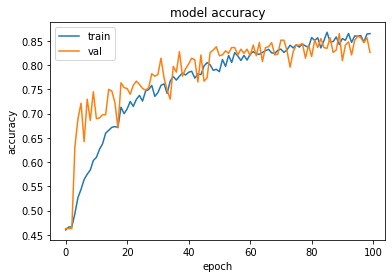

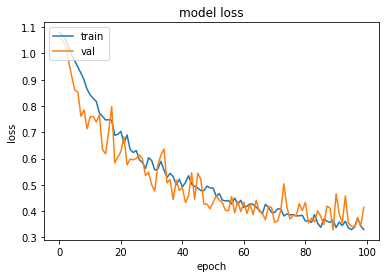

In [48]:
#Analyze AlexNet Patient Level
plt.plot(Alex_history.history['accuracy'])
plt.plot(Alex_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(Alex_history.history['loss'])
plt.plot(Alex_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

    We could get accuracy about %90.
    
    AlexNet has less variance than ResNet. it has a smoother loss and accuracy plot.

    I think if we had more epochs, we could get better performance.(I was limited on GPU to test it)

##Design the Multi-Layer Perceptron model (20 pt)

We want to implement a Multi layer perceptron deep network to classify our dataset too.

Do the steps as you did in other models.

In [30]:
#Preprocessing MLP Image level
image_size = 128
batch_size = 32
train_dir =  '/content/training'
val_dir =  '/content/validation'
train_data = ImageDataGenerator(
        rescale = 1/255,
        shear_range = 10,
        zoom_range = .3,
        horizontal_flip = True,
        vertical_flip = True,
        width_shift_range = .2,
        rotation_range = 20,
        #zca_whitening=True,
        fill_mode = 'nearest'
    ) 
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(image_size,image_size))
val_data = ImageDataGenerator(
    rescale = 1/255
    )
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(image_size,image_size))

Found 2450 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [47]:
#Creating Model
MLP_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[128,128,3]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [48]:
MLP_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 49152)             0         
                                                                 
 dense_25 (Dense)            (None, 300)               14745900  
                                                                 
 dense_26 (Dense)            (None, 100)               30100     
                                                                 
 dense_27 (Dense)            (None, 3)                 303       
                                                                 
Total params: 14,776,303
Trainable params: 14,776,303
Non-trainable params: 0
_________________________________________________________________


###Train the model (10pt)

In [49]:
#Compile MLP
opt = keras.optimizers.Adam(learning_rate=0.00001)
MLP_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [54]:
#Train MLP
MLP_history = MLP_model.fit(traindata, validation_data = valdata, batch_size = batch_size, epochs = 500)

Epoch 1/500
77/77 [==============================] - 10s 125ms/step - loss: 0.8199 - accuracy: 0.6416 - recall_6: 0.5269 - precision_6: 0.6863 - val_loss: 0.7801 - val_accuracy: 0.6792 - val_recall_6: 0.5423 - val_precision_6: 0.7551
Epoch 2/500
77/77 [==============================] - 10s 124ms/step - loss: 0.8114 - accuracy: 0.6367 - recall_6: 0.5220 - precision_6: 0.6880 - val_loss: 0.7671 - val_accuracy: 0.6694 - val_recall_6: 0.4919 - val_precision_6: 0.7646
Epoch 3/500
77/77 [==============================] - 10s 125ms/step - loss: 0.8223 - accuracy: 0.6502 - recall_6: 0.5229 - precision_6: 0.6898 - val_loss: 0.7841 - val_accuracy: 0.6629 - val_recall_6: 0.4870 - val_precision_6: 0.7401
Epoch 4/500
77/77 [==============================] - 10s 125ms/step - loss: 0.8272 - accuracy: 0.6253 - recall_6: 0.5118 - precision_6: 0.6786 - val_loss: 0.8266 - val_accuracy: 0.6124 - val_recall_6: 0.4967 - val_precision_6: 0.6823
Epoch 5/500
77/77 [==============================] - 10s 125ms/s

Epoch 36/500
77/77 [==============================] - 10s 124ms/step - loss: 0.8053 - accuracy: 0.6412 - recall_6: 0.5331 - precision_6: 0.6914 - val_loss: 0.7481 - val_accuracy: 0.6840 - val_recall_6: 0.5765 - val_precision_6: 0.7390
Epoch 37/500
77/77 [==============================] - 10s 123ms/step - loss: 0.8151 - accuracy: 0.6494 - recall_6: 0.5282 - precision_6: 0.7033 - val_loss: 0.7783 - val_accuracy: 0.6564 - val_recall_6: 0.5163 - val_precision_6: 0.7338
Epoch 38/500
77/77 [==============================] - 10s 123ms/step - loss: 0.8163 - accuracy: 0.6359 - recall_6: 0.5216 - precision_6: 0.6856 - val_loss: 0.7638 - val_accuracy: 0.6792 - val_recall_6: 0.5423 - val_precision_6: 0.7517
Epoch 39/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7980 - accuracy: 0.6502 - recall_6: 0.5302 - precision_6: 0.7056 - val_loss: 0.8059 - val_accuracy: 0.6482 - val_recall_6: 0.4919 - val_precision_6: 0.7366
Epoch 40/500
77/77 [==============================] - 10s 12

Epoch 71/500
77/77 [==============================] - 10s 125ms/step - loss: 0.7751 - accuracy: 0.6682 - recall_6: 0.5576 - precision_6: 0.7167 - val_loss: 0.7255 - val_accuracy: 0.7085 - val_recall_6: 0.5847 - val_precision_6: 0.7448
Epoch 72/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7792 - accuracy: 0.6608 - recall_6: 0.5657 - precision_6: 0.7104 - val_loss: 0.7932 - val_accuracy: 0.6547 - val_recall_6: 0.5456 - val_precision_6: 0.7251
Epoch 73/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7954 - accuracy: 0.6563 - recall_6: 0.5547 - precision_6: 0.7074 - val_loss: 0.8333 - val_accuracy: 0.6466 - val_recall_6: 0.5195 - val_precision_6: 0.7011
Epoch 74/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7945 - accuracy: 0.6592 - recall_6: 0.5478 - precision_6: 0.7071 - val_loss: 0.8072 - val_accuracy: 0.6384 - val_recall_6: 0.5033 - val_precision_6: 0.7305
Epoch 75/500
77/77 [==============================] - 10s 12

Epoch 106/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7798 - accuracy: 0.6710 - recall_6: 0.5576 - precision_6: 0.7115 - val_loss: 0.7186 - val_accuracy: 0.7052 - val_recall_6: 0.5765 - val_precision_6: 0.7797
Epoch 107/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7820 - accuracy: 0.6596 - recall_6: 0.5653 - precision_6: 0.7052 - val_loss: 0.7328 - val_accuracy: 0.7101 - val_recall_6: 0.5684 - val_precision_6: 0.7790
Epoch 108/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7932 - accuracy: 0.6563 - recall_6: 0.5616 - precision_6: 0.7038 - val_loss: 0.7291 - val_accuracy: 0.7215 - val_recall_6: 0.5749 - val_precision_6: 0.7775
Epoch 109/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7860 - accuracy: 0.6702 - recall_6: 0.5629 - precision_6: 0.7224 - val_loss: 0.7546 - val_accuracy: 0.6906 - val_recall_6: 0.5554 - val_precision_6: 0.7365
Epoch 110/500
77/77 [==============================] - 1

Epoch 141/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7730 - accuracy: 0.6596 - recall_6: 0.5559 - precision_6: 0.7116 - val_loss: 0.7235 - val_accuracy: 0.7085 - val_recall_6: 0.5733 - val_precision_6: 0.7770
Epoch 142/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7655 - accuracy: 0.6751 - recall_6: 0.5845 - precision_6: 0.7240 - val_loss: 0.7000 - val_accuracy: 0.7248 - val_recall_6: 0.6107 - val_precision_6: 0.7560
Epoch 143/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7667 - accuracy: 0.6653 - recall_6: 0.5678 - precision_6: 0.7075 - val_loss: 0.7588 - val_accuracy: 0.6840 - val_recall_6: 0.5798 - val_precision_6: 0.7134
Epoch 144/500
77/77 [==============================] - 10s 125ms/step - loss: 0.7649 - accuracy: 0.6722 - recall_6: 0.5669 - precision_6: 0.7145 - val_loss: 0.7393 - val_accuracy: 0.7036 - val_recall_6: 0.5603 - val_precision_6: 0.7611
Epoch 145/500
77/77 [==============================] - 1

Epoch 176/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7640 - accuracy: 0.6718 - recall_6: 0.5886 - precision_6: 0.7199 - val_loss: 0.7471 - val_accuracy: 0.6824 - val_recall_6: 0.5554 - val_precision_6: 0.7286
Epoch 177/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7587 - accuracy: 0.6796 - recall_6: 0.5931 - precision_6: 0.7222 - val_loss: 0.7606 - val_accuracy: 0.6629 - val_recall_6: 0.5765 - val_precision_6: 0.7152
Epoch 178/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7468 - accuracy: 0.6751 - recall_6: 0.5816 - precision_6: 0.7143 - val_loss: 0.7279 - val_accuracy: 0.7085 - val_recall_6: 0.5896 - val_precision_6: 0.7669
Epoch 179/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7651 - accuracy: 0.6735 - recall_6: 0.5763 - precision_6: 0.7160 - val_loss: 0.7235 - val_accuracy: 0.7117 - val_recall_6: 0.5945 - val_precision_6: 0.7636
Epoch 180/500
77/77 [==============================] - 1

Epoch 211/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7506 - accuracy: 0.6824 - recall_6: 0.6053 - precision_6: 0.7316 - val_loss: 0.7055 - val_accuracy: 0.7492 - val_recall_6: 0.6107 - val_precision_6: 0.7928
Epoch 212/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7443 - accuracy: 0.6824 - recall_6: 0.5910 - precision_6: 0.7236 - val_loss: 0.7391 - val_accuracy: 0.7166 - val_recall_6: 0.5896 - val_precision_6: 0.7605
Epoch 213/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7448 - accuracy: 0.6796 - recall_6: 0.5873 - precision_6: 0.7235 - val_loss: 0.6931 - val_accuracy: 0.7524 - val_recall_6: 0.6189 - val_precision_6: 0.8017
Epoch 214/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7515 - accuracy: 0.6853 - recall_6: 0.5869 - precision_6: 0.7288 - val_loss: 0.6884 - val_accuracy: 0.7215 - val_recall_6: 0.6450 - val_precision_6: 0.7719
Epoch 215/500
77/77 [==============================] - 1

Epoch 246/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7189 - accuracy: 0.7078 - recall_6: 0.6114 - precision_6: 0.7394 - val_loss: 0.7730 - val_accuracy: 0.6775 - val_recall_6: 0.6042 - val_precision_6: 0.7053
Epoch 247/500
77/77 [==============================] - 10s 126ms/step - loss: 0.7374 - accuracy: 0.6829 - recall_6: 0.6012 - precision_6: 0.7224 - val_loss: 0.6780 - val_accuracy: 0.7329 - val_recall_6: 0.6482 - val_precision_6: 0.7713
Epoch 248/500
77/77 [==============================] - 10s 125ms/step - loss: 0.7366 - accuracy: 0.6898 - recall_6: 0.6094 - precision_6: 0.7369 - val_loss: 0.6782 - val_accuracy: 0.7231 - val_recall_6: 0.6498 - val_precision_6: 0.7586
Epoch 249/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7273 - accuracy: 0.6943 - recall_6: 0.6159 - precision_6: 0.7361 - val_loss: 0.6980 - val_accuracy: 0.7264 - val_recall_6: 0.6466 - val_precision_6: 0.7605
Epoch 250/500
77/77 [==============================] - 1

Epoch 281/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7228 - accuracy: 0.6882 - recall_6: 0.6053 - precision_6: 0.7367 - val_loss: 0.6743 - val_accuracy: 0.7427 - val_recall_6: 0.6612 - val_precision_6: 0.7868
Epoch 282/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7368 - accuracy: 0.6935 - recall_6: 0.6122 - precision_6: 0.7243 - val_loss: 0.7088 - val_accuracy: 0.7182 - val_recall_6: 0.6303 - val_precision_6: 0.7633
Epoch 283/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7248 - accuracy: 0.7000 - recall_6: 0.6269 - precision_6: 0.7449 - val_loss: 0.7565 - val_accuracy: 0.6775 - val_recall_6: 0.5423 - val_precision_6: 0.7287
Epoch 284/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7300 - accuracy: 0.6943 - recall_6: 0.6069 - precision_6: 0.7380 - val_loss: 0.6969 - val_accuracy: 0.7020 - val_recall_6: 0.6319 - val_precision_6: 0.7534
Epoch 285/500
77/77 [==============================] - 1

Epoch 316/500
77/77 [==============================] - 9s 122ms/step - loss: 0.7250 - accuracy: 0.6955 - recall_6: 0.6102 - precision_6: 0.7354 - val_loss: 0.6900 - val_accuracy: 0.7199 - val_recall_6: 0.6401 - val_precision_6: 0.7529
Epoch 317/500
77/77 [==============================] - 10s 127ms/step - loss: 0.7171 - accuracy: 0.7004 - recall_6: 0.6163 - precision_6: 0.7449 - val_loss: 0.6867 - val_accuracy: 0.7215 - val_recall_6: 0.6368 - val_precision_6: 0.7563
Epoch 318/500
77/77 [==============================] - 10s 126ms/step - loss: 0.7319 - accuracy: 0.6861 - recall_6: 0.6061 - precision_6: 0.7297 - val_loss: 0.7217 - val_accuracy: 0.7036 - val_recall_6: 0.6270 - val_precision_6: 0.7404
Epoch 319/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7342 - accuracy: 0.6971 - recall_6: 0.6167 - precision_6: 0.7356 - val_loss: 0.6930 - val_accuracy: 0.7150 - val_recall_6: 0.6694 - val_precision_6: 0.7569
Epoch 320/500
77/77 [==============================] - 10

Epoch 351/500
77/77 [==============================] - 9s 123ms/step - loss: 0.7123 - accuracy: 0.7102 - recall_6: 0.6351 - precision_6: 0.7502 - val_loss: 0.6450 - val_accuracy: 0.7427 - val_recall_6: 0.6775 - val_precision_6: 0.7834
Epoch 352/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7187 - accuracy: 0.7020 - recall_6: 0.6208 - precision_6: 0.7334 - val_loss: 0.6906 - val_accuracy: 0.7248 - val_recall_6: 0.6629 - val_precision_6: 0.7665
Epoch 353/500
77/77 [==============================] - 9s 122ms/step - loss: 0.7034 - accuracy: 0.7033 - recall_6: 0.6269 - precision_6: 0.7537 - val_loss: 0.6380 - val_accuracy: 0.7459 - val_recall_6: 0.6743 - val_precision_6: 0.7767
Epoch 354/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7120 - accuracy: 0.7045 - recall_6: 0.6327 - precision_6: 0.7492 - val_loss: 0.6700 - val_accuracy: 0.7248 - val_recall_6: 0.6531 - val_precision_6: 0.7566
Epoch 355/500
77/77 [==============================] - 9s 

Epoch 386/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6971 - accuracy: 0.7151 - recall_6: 0.6445 - precision_6: 0.7480 - val_loss: 0.7166 - val_accuracy: 0.6824 - val_recall_6: 0.6189 - val_precision_6: 0.7252
Epoch 387/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6973 - accuracy: 0.7008 - recall_6: 0.6322 - precision_6: 0.7440 - val_loss: 0.6712 - val_accuracy: 0.7182 - val_recall_6: 0.6645 - val_precision_6: 0.7556
Epoch 388/500
77/77 [==============================] - 9s 123ms/step - loss: 0.7051 - accuracy: 0.7082 - recall_6: 0.6286 - precision_6: 0.7472 - val_loss: 0.7200 - val_accuracy: 0.6971 - val_recall_6: 0.6059 - val_precision_6: 0.7410
Epoch 389/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6883 - accuracy: 0.7131 - recall_6: 0.6412 - precision_6: 0.7463 - val_loss: 0.6763 - val_accuracy: 0.7296 - val_recall_6: 0.6401 - val_precision_6: 0.7721
Epoch 390/500
77/77 [==============================] - 9s 12

Epoch 421/500
77/77 [==============================] - 10s 124ms/step - loss: 0.7004 - accuracy: 0.7024 - recall_6: 0.6339 - precision_6: 0.7427 - val_loss: 0.7712 - val_accuracy: 0.6580 - val_recall_6: 0.5831 - val_precision_6: 0.6858
Epoch 422/500
77/77 [==============================] - 10s 123ms/step - loss: 0.7004 - accuracy: 0.7049 - recall_6: 0.6298 - precision_6: 0.7440 - val_loss: 0.6242 - val_accuracy: 0.7378 - val_recall_6: 0.6726 - val_precision_6: 0.7763
Epoch 423/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6995 - accuracy: 0.7053 - recall_6: 0.6380 - precision_6: 0.7475 - val_loss: 0.6132 - val_accuracy: 0.7606 - val_recall_6: 0.6564 - val_precision_6: 0.7902
Epoch 424/500
77/77 [==============================] - 9s 123ms/step - loss: 0.7094 - accuracy: 0.7069 - recall_6: 0.6335 - precision_6: 0.7426 - val_loss: 0.6826 - val_accuracy: 0.7329 - val_recall_6: 0.6319 - val_precision_6: 0.7854
Epoch 425/500
77/77 [==============================] - 9s 

Epoch 456/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6871 - accuracy: 0.7163 - recall_6: 0.6449 - precision_6: 0.7531 - val_loss: 0.6477 - val_accuracy: 0.7296 - val_recall_6: 0.6678 - val_precision_6: 0.7750
Epoch 457/500
77/77 [==============================] - 9s 122ms/step - loss: 0.6816 - accuracy: 0.7155 - recall_6: 0.6539 - precision_6: 0.7549 - val_loss: 0.6484 - val_accuracy: 0.7362 - val_recall_6: 0.7036 - val_precision_6: 0.7687
Epoch 458/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6871 - accuracy: 0.7143 - recall_6: 0.6498 - precision_6: 0.7603 - val_loss: 0.6404 - val_accuracy: 0.7427 - val_recall_6: 0.6678 - val_precision_6: 0.7795
Epoch 459/500
77/77 [==============================] - 10s 123ms/step - loss: 0.6854 - accuracy: 0.7082 - recall_6: 0.6335 - precision_6: 0.7458 - val_loss: 0.6829 - val_accuracy: 0.7248 - val_recall_6: 0.6287 - val_precision_6: 0.7628
Epoch 460/500
77/77 [==============================] - 9s 1

Epoch 491/500
77/77 [==============================] - 10s 123ms/step - loss: 0.6730 - accuracy: 0.7196 - recall_6: 0.6457 - precision_6: 0.7584 - val_loss: 0.6990 - val_accuracy: 0.6987 - val_recall_6: 0.6352 - val_precision_6: 0.7471
Epoch 492/500
77/77 [==============================] - 9s 123ms/step - loss: 0.6731 - accuracy: 0.7192 - recall_6: 0.6596 - precision_6: 0.7541 - val_loss: 0.6373 - val_accuracy: 0.7443 - val_recall_6: 0.6759 - val_precision_6: 0.7757
Epoch 493/500
77/77 [==============================] - 10s 123ms/step - loss: 0.6994 - accuracy: 0.7114 - recall_6: 0.6510 - precision_6: 0.7566 - val_loss: 0.6755 - val_accuracy: 0.7280 - val_recall_6: 0.6287 - val_precision_6: 0.7689
Epoch 494/500
77/77 [==============================] - 10s 124ms/step - loss: 0.6772 - accuracy: 0.7159 - recall_6: 0.6535 - precision_6: 0.7570 - val_loss: 0.6301 - val_accuracy: 0.7394 - val_recall_6: 0.6564 - val_precision_6: 0.7917
Epoch 495/500
77/77 [==============================] - 9s

In [ ]:
# I forgot to calculate F1-score during the training. 
# Since it was time consuming to train it again, I calculate F1-score separately.
temp1 = [2*a*b for a,b in zip(MLP_history.history['val_precision_6'] , MLP_history.history['val_recall_6'])]
temp2 = [a+b for a,b in zip(MLP_history.history['val_precision_6'] , MLP_history.history['val_recall_6'])]
F1_score = [a/b for a,b in zip(temp1, temp2)]

###Loss and accuracy diagrams for multi-layer perceptron (10 pt)


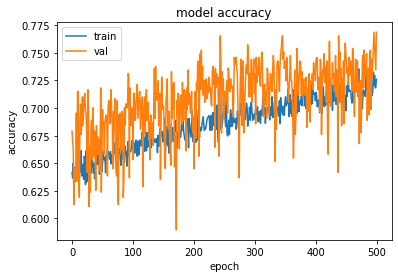

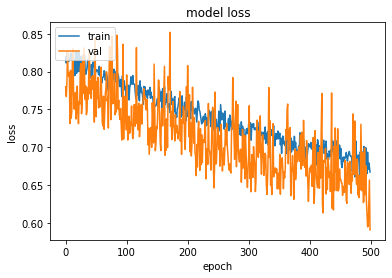

In [55]:
#Analize MLP
plt.plot(MLP_history.history['accuracy'])
plt.plot(MLP_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

    Now answer these questions:

1- How close are your answers to those in the paper?

2- Why do you think they aren't close if they aren't?

3- What suggestions do you have for improving any of these methods?

4- Compare the results from these 3 models. How would you rate each method in terms of its effectiveness?

5- Can we trust our answer for any MRI image of a patient? Answer the question in detail.

    Answers:

    1- I got not exactly the result in the paper but little close to them. the main difference is that our models has  higher variance in loss and accuracy than the ones in the paper.

    2,3- I think if we had more epochs and make the lr smaller step by step, we could get better results.

    4- AlexNet is more effective if we run it on more epochs and after that ResNet. MLP can be effective if make it more deeper i think.

    5- I don't know what it means by "any MRI image" but if you mean the type of the MRI image, i think if we 
    train our model on T1 iamges(or T2) but not together and on the patient level, we can use this model for 
    images for new patient(T1 new patient for T1 model and T2 new patient for T2 model). to be sure، we can do             Interpretability testing and consult the result with an expert(doctor)